In [1]:
from voc_dataset import VOCDetection
from config import opt
import numpy as np
from lib.vgg_model import VGG_SSD
from lib.res_model import RES18_SSD, RES101_SSD
from lib.resnet import *
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
from voc_dataset import VOC_LABELS

%matplotlib inline

c:\Users\David Root\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("cuda") 
else:
    print("not")

cuda


In [67]:
VOC_CLASSES = ( 
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

### load model

In [3]:
#model = VGG_SSD(opt.num_classes, opt.anchor_num)
model = RES18_SSD(opt.num_classes, opt.anchor_num,pretrain=False)
#model = RES101_SSD(opt.num_classes, opt.anchor_num,pretrain=False)

state_dict = torch.load('./weights/resnet18-5c106cde.pth', map_location='cpu')
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=False)



_IncompatibleKeys(missing_keys=['L2Norm.weight', 'res.0.weight', 'res.1.weight', 'res.1.bias', 'res.1.running_mean', 'res.1.running_var', 'res.4.0.conv1.weight', 'res.4.0.bn1.weight', 'res.4.0.bn1.bias', 'res.4.0.bn1.running_mean', 'res.4.0.bn1.running_var', 'res.4.0.conv2.weight', 'res.4.0.bn2.weight', 'res.4.0.bn2.bias', 'res.4.0.bn2.running_mean', 'res.4.0.bn2.running_var', 'res.4.1.conv1.weight', 'res.4.1.bn1.weight', 'res.4.1.bn1.bias', 'res.4.1.bn1.running_mean', 'res.4.1.bn1.running_var', 'res.4.1.conv2.weight', 'res.4.1.bn2.weight', 'res.4.1.bn2.bias', 'res.4.1.bn2.running_mean', 'res.4.1.bn2.running_var', 'res.5.0.conv1.weight', 'res.5.0.bn1.weight', 'res.5.0.bn1.bias', 'res.5.0.bn1.running_mean', 'res.5.0.bn1.running_var', 'res.5.0.conv2.weight', 'res.5.0.bn2.weight', 'res.5.0.bn2.bias', 'res.5.0.bn2.running_mean', 'res.5.0.bn2.running_var', 'res.5.0.downsample.0.weight', 'res.5.0.downsample.1.weight', 'res.5.0.downsample.1.bias', 'res.5.0.downsample.1.running_mean', 'res.5.0

### anchors

In [69]:
multibox_encoder = MultiBoxEncoder(opt)

### load and preprocess image

In [70]:
image = 'images/000004.jpg'
src = cv2.imread(image, cv2.IMREAD_COLOR)
image = preproc_for_test(src, opt.min_size, opt.mean)
image = torch.from_numpy(image)

### predict

In [71]:
with torch.no_grad():
    loc, conf = model(image.unsqueeze(0))

### convert torch ----> numpy

In [72]:
loc = loc[0]
conf = conf[0]
conf = F.softmax(conf, dim=1)
conf = conf.numpy()
loc = loc.numpy()

### decode location

In [73]:
decode_loc = multibox_encoder.decode(loc)

### detect

In [74]:
gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.45, gt_threshold=0.1)

### map locations back to original image

In [75]:
h, w = src.shape[:2]
gt_boxes[:, 0] = gt_boxes[:, 0] * w
gt_boxes[:, 1] = gt_boxes[:, 1] * h
gt_boxes[:, 2] = gt_boxes[:, 2] * w
gt_boxes[:, 3] = gt_boxes[:, 3] * h
gt_boxes = gt_boxes.astype(int)

### show

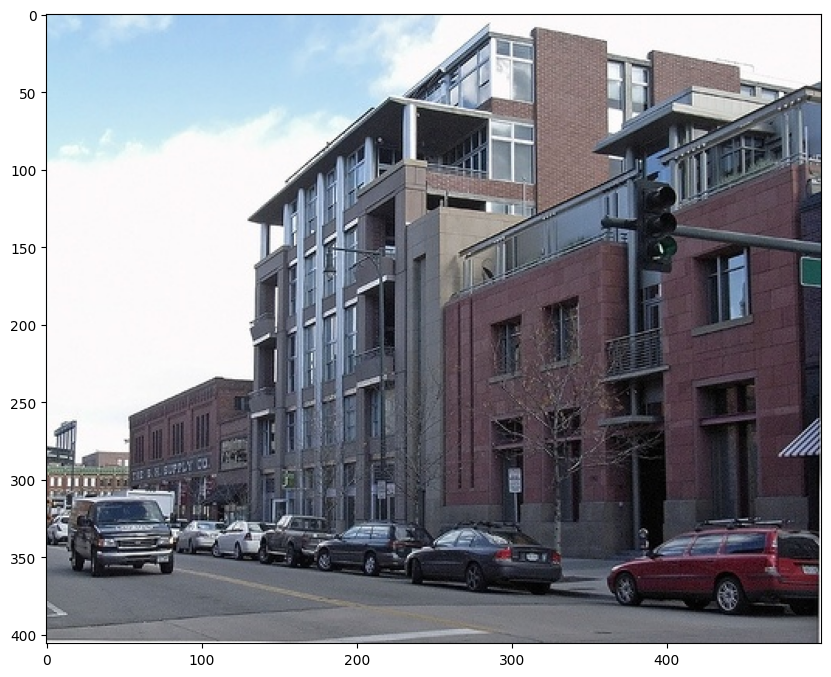

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(src[:, :, ::-1])

0 0.7352666 367 63 491 125
0 0.67013973 160 78 261 168
0 0.64279026 220 41 315 109
0 0.6311867 321 37 418 106
0 0.6297831 181 50 289 134
0 0.62085855 57 314 146 398
0 0.5914885 55 297 197 370
0 0.5840025 318 82 365 141
0 0.5804515 105 332 192 423
0 0.54321164 110 76 207 161
0 0.5185229 155 220 265 320
0 0.50226 151 62 248 133
0 0.49489135 135 197 244 284
0 0.486732 101 140 197 219
0 0.46449322 201 89 315 175
0 0.45977002 54 203 150 294
0 0.45772916 404 290 542 373
0 0.45630074 -7 376 29 431
0 0.43462634 220 -8 311 59
0 0.43407878 80 114 165 174
0 0.43389297 238 355 270 396
0 0.4324215 4 339 100 405
0 0.42485392 91 181 204 268
0 0.4123136 396 140 503 214
0 0.40869126 270 165 304 207
0 0.40257174 431 11 521 93
0 0.39667055 284 121 320 168
0 0.3953724 157 354 250 445
0 0.38476402 178 118 288 189
0 0.38377744 0 278 105 360
0 0.38083896 332 367 362 409
0 0.38007417 52 350 79 397
0 0.3777068 309 118 344 164
0 0.37633273 342 11 451 100
0 0.3758151 317 143 349 185
0 0.37386116 162 108 247 217


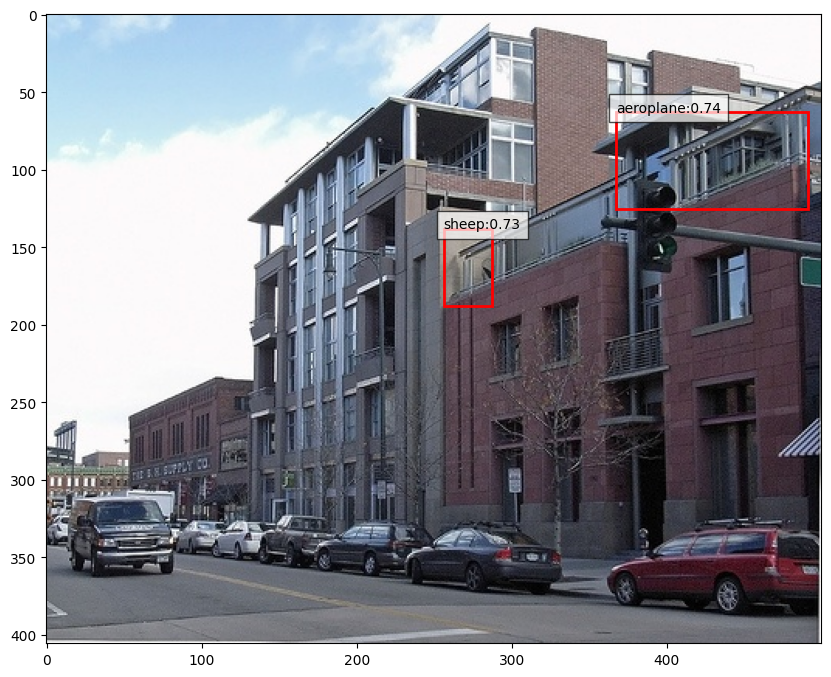

In [77]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(src[:, :, ::-1])
for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
        print(label, score, *box)
        if score > 0.7:
            text = '{:s}:{:.2f}'.format(VOC_LABELS[label], score)
            ax.add_patch(
                plt.Rectangle(
                (box[0], box[1]), 
                 box[2] - box[0], 
                 box[3] - box[1],
                 fill=False, 
                 edgecolor='red',
                 linewidth=2)
            )
            ax.text(box[0], box[1], text,
                    bbox={'facecolor' : 'white', 'alpha' : 0.7, 'pad' : 5}
                   )
plt.savefig('images/2.jpg')